<a href="https://colab.research.google.com/github/itsigorjozwiak/visualization-of-yacht-routes-on-a-map/blob/main/WizualizacjaTras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projekt: Wizualizacja tras jachtu na mapie 🛥️

Autorzy: Jakub Pawlusek, Igor Jóźwiak, Adriana Jarosz, Agnieszka Jagosz

Na początek jaki jest cel naszego projektu?

Jest nim pokazanie, jak za pomocą danych z pliku .gpx i historycznych danych pogodowych można:

1. Zmapować trasę jachtu,
2. Nałożyć dane o warunkach atmosferycznych,
3. Zwizualizować je interaktywnie i wykresowo.


Na początku instalujemy niezbędne biblioteki do pracy z danymi geograficznymi, meteorologicznymi i ich wizualizacją.

Biblioteki, które pobieramy to:

1. gpxpy: czyli biblioteka do przetwarzania plików .gpx, które zawierają dane GPS (pozycje, ścieżki).

2. folium: Narzędzie do tworzenia interaktywnych map (bazujące na Leaflet.js).

3. meteostat: API i narzędzie do pobierania danych pogodowych (np. kierunek i siła wiatru).

In [ ]:
!pip install gpxpy folium meteostat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


Następnym krokiem jest importowanie wszystkich bibliotek, których potrzebujemy: do analizy danych, obsługi plików .gpx, pobierania danych pogodowych i wizualizacji.

In [ ]:
# Biblioteki do przetwarzania danych
import pandas as pd
import numpy as np
import datetime

# Biblioteka do odczytu pliku .gpx
import gpxpy
import gpxpy.gpx

# Biblioteki do pobierania danych na podstawie lokalizacji oraz czasu
import requests
from meteostat import Stations, Hourly, Point

# Wizualizacja map oraz wykresów
import folium
from folium.plugins import AntPath
import matplotlib.pyplot as plt
import seaborn as sns

# Biblioteka dla paska postępu
from tqdm import tqdm

Wczytujemy dane trasy jachtu z pliku .gpx i zamieniamy je na DataFrame, którą
łatwo później analizować i na niej pracować.



In [ ]:
# Załaduj plik GPX z lokalizacji
from google.colab import files
uploaded = files.upload()

# Wczytanie pliku GPX
with open(next(iter(uploaded))) as gpx_file:
    gpx = gpxpy.parse(gpx_file) # analizuje plik i pozwala wyodrębnić punkty trasy

# tworzymy listę punktów z informacjami o czasie, szerokości, długości i wysokości.
points = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            points.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation
            })

df_gpx = pd.DataFrame(points) # DataFrame z danymi geograficznymi
df_gpx['time'] = pd.to_datetime(df_gpx['time']).dt.tz_localize(None)
df_gpx.head()

Saving explore (3).gpx to explore (3).gpx


,time,latitude,longitude,elevation
0,2024-06-01 19:15:15,54.369846,18.664848,-1.70
1,2024-06-01 19:25:15,54.383536,18.661845,18.57
2,2024-06-01 19:35:15,54.395650,18.676478,16.54
3,2024-06-01 19:45:15,54.404898,18.669805,14.51
4,2024-06-01 19:55:15,54.415808,18.657746,16.54


Kod ustala zakres czasowy trasy na podstawie danych GPS, oblicza średnie współrzędne geograficzne  trasy, aby znaleźć najbliższą stację meteorologiczną Meteostat. Na końcu pobiera z tej stacji godzinowe dane pogodowe, wybiera potrzebne kolumny i sortuje je

In [ ]:
# Czas bez strefy
start_time = df_gpx['time'].min().tz_localize(None)
end_time = df_gpx['time'].max().tz_localize(None)

# Średnia lokalizacja trasy
mean_lat = df_gpx['latitude'].mean()
mean_lon = df_gpx['longitude'].mean()

# Znajdź najbliższą stację Meteostat
stations = Stations()
stations = stations.nearby(mean_lat, mean_lon) # znalezenie najblizszej stacji pogodowej
station = stations.fetch(1)

# Pobierz dane godzinowe z tej stacji
data_hourly = Hourly(station.index[0], start_time, end_time)
df_meteo = data_hourly.fetch().reset_index()

# Zostaw tylko potrzebne kolumny i je posortuj
df_meteo = df_meteo[['time', 'wdir', 'wspd', 'temp', 'pres']]
df_meteo['time'] = pd.to_datetime(df_meteo['time'])
df_meteo = df_meteo.sort_values('time')

Łączymy dane GPS i meteorologiczne w jeden zbiór, dopasowując po czasie (najbliższa godzina).

In [ ]:
# Upewniamy sie ze dane sa posortowane wedlug czasu
df_gpx['time'] = pd.to_datetime(df_gpx['time'])
df_gpx = df_gpx.sort_values('time')

# Dopasowanie najbliższej wcześniejszej godziny
df_combined = pd.merge_asof(df_gpx, df_meteo, on='time', direction='nearest')

Sprawdzamy podstawowe informacje o danych pogodowych – średnie, odchylenia, wartości min i max, żeby upewnić się, że dane są poprawne.

In [ ]:
df_combined.head()
df_combined[['wdir', 'wspd', 'temp', 'pres']].describe() # generujemy statystyki opisowe

,wdir,wspd,temp,pres
count,1319.0,1319.0,1319.0,1319.0
mean,230.404094,25.743745,13.870129,1009.475436
std,51.116737,7.756197,2.479599,4.51207
min,108.0,7.4,8.7,993.2
25%,194.0,20.4,12.1,1008.1
50%,237.0,25.9,13.9,1010.1
75%,262.0,31.5,15.5,1011.6
max,345.0,46.3,20.6,1018.3


Teraz tworzymy wykresy zmian pogodowych na trasie na podstawie otrzymanych danych.

Pierwszy wykres to wykres zależności prędkości wiatru w czasie na trasie jachtu.

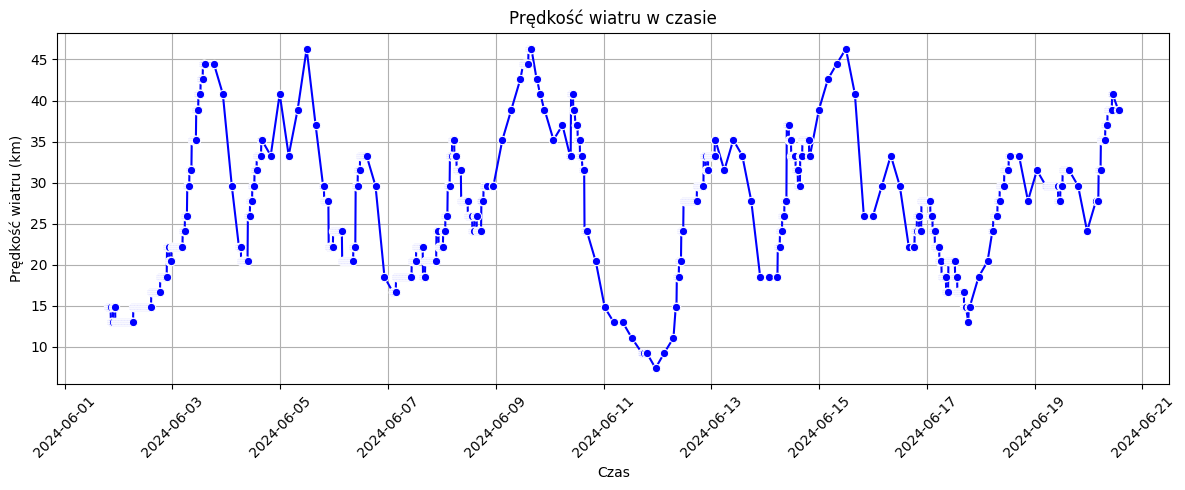

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_combined, x='time', y='wspd', marker='o', color='blue')
plt.title('Prędkość wiatru w czasie')
plt.xlabel('Czas')
plt.ylabel('Prędkość wiatru (km)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Kolejny wykres pokazuje nam zmiany temperatury w czasie przepływu jachtu.

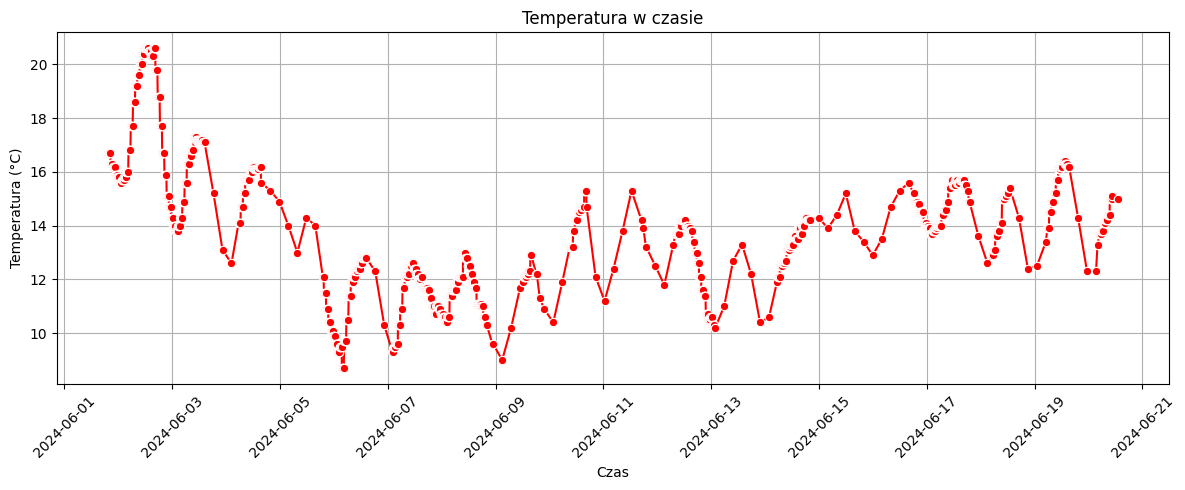

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_combined, x='time', y='temp', marker='o', color='red')
plt.title('Temperatura w czasie')
plt.xlabel('Czas')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ostatni wykres pokazuje nam zmiany ciśnienia atmosferycznego w czasie trasy jachtu.

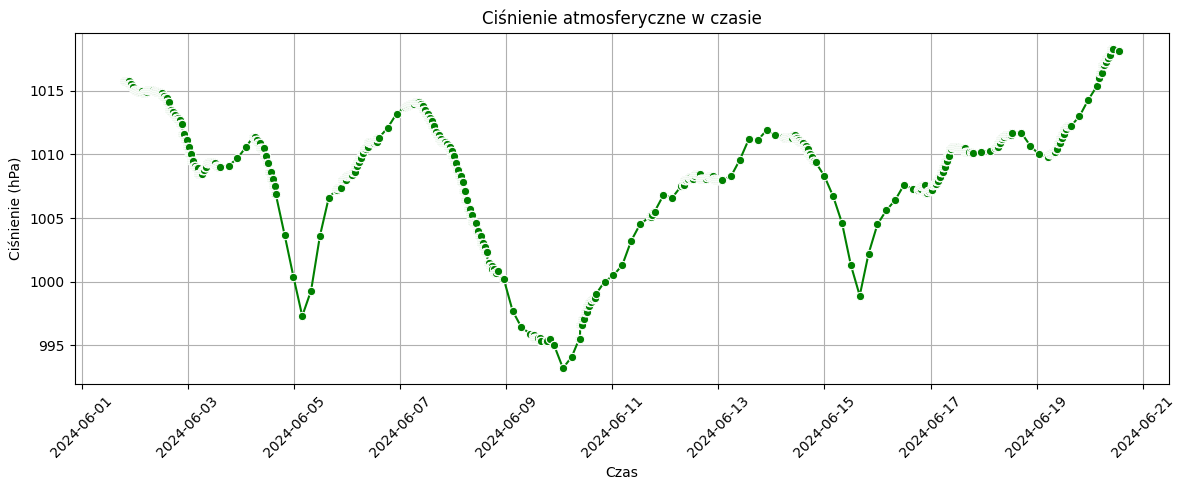

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_combined, x='time', y='pres', marker='o', color='green')
plt.title('Ciśnienie atmosferyczne w czasie')
plt.xlabel('Czas')
plt.ylabel('Ciśnienie (hPa)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Na koniec najważniejsza część zadania czyli wizualizacja trasy na mapie z możliwością interakcyjną sprawdzania warunków w punktach przepływu oraz pokazującą kierunek wiatru etc.

In [ ]:
import folium
import numpy as np
from folium import plugins

# Tworzymy mapę
# Używamy średniej lokalizacji z df_gpx do inicjalizacji mapy, tak jak wcześniej
m = folium.Map(location=[df_gpx['latitude'].mean(), df_gpx['longitude'].mean()], zoom_start=10)

# Kolor zależny od prędkości wiatru
def wind_color(wspd):
    if wspd < 10:
        return 'green'
    elif wspd < 20:
        return 'orange'
    else:
        return 'red'

# Dodajemy punkty trasy z popupem i strzałką wiatru
# Iterujemy przez df_combined, które zawiera dane GPX i pogodowe
for i, row in df_combined.iterrows():
    # Sprawdzamy, czy dane pogodowe są dostępne dla danego punktu
    if pd.isna(row['wdir']) or pd.isna(row['wspd']):
        continue

    color = wind_color(row['wspd'])
    popup_text = (
        f"<b>Czas:</b> {row['time']}<br>"
        f"<b>Wiatr:</b> {row['wspd']:.2f} kn, {row['wdir']:.0f}°<br>" # Formatowanie dla lepszej czytelności
        f"<b>Temp:</b> {row['temp']:.1f} °C<br>"
        f"<b>Ciśnienie:</b> {row['pres']:.0f} hPa"
    )

    # Marker
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=10,
        color=color,
        fill=True,
        fill_opacity=0.9,
        popup=popup_text
    ).add_to(m)

    # Strzałka wiatru (wektor)
    # Skalujemy długość strzałki, np. w zależności od prędkości wiatru, lub używamy stałej
    arrow_scale = 0.005 * (row['wspd'] / df_combined['wspd'].max()) # Przykładowe skalowanie
    # Używamy kierunku wiatru (wdir) do obliczenia kierunku strzałki. 0deg = Północ
    # Wiatru podaje się kierunek z którego wieje, więc strzałka powinna wskazywać w kierunku, w którym wieje wiatr (wdir + 180)
    wind_direction_rad = np.radians(row['wdir'] + 180)
    dx = arrow_scale * np.sin(wind_direction_rad)
    dy = arrow_scale * np.cos(wind_direction_rad)

    folium.PolyLine(
        locations=[
            [row['latitude'], row['longitude']],
            [row['latitude'] + dy, row['longitude'] + dx]
        ],
        color=color,
        weight=12,
        opacity=1.0
    ).add_to(m)

# Dodajemy linię trasy - można użyć df_gpx lub df_combined, obie mają kolumny latitude i longitude
folium.PolyLine(
    locations=df_gpx[['latitude', 'longitude']].values, # Używamy oryginalnych punktów GPX dla linii trasy
    color='blue',
    weight=2
).add_to(m)

# Wyświetlamy mapę
m